In [1]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
from os import listdir
from pickle import dump
from keras.applications.inception_v3 import InceptionV3
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
import warnings
import pandas as pd
from google.colab import drive

warnings.filterwarnings("ignore")

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = InceptionV3()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the inception model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
#         print('>%s' % name)
    return features

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#location of the data
data_location =  "/content/drive/MyDrive/wrk_dir"
!ls $data_location

image_path = data_location+"/flickr8k/images/"
caption_file = data_location + '/cpt/captions.txt'
dev_dataset = data_location + '/txt/Flickr_8k.devImages.txt'
test_dataset = data_location + '/txt/Flickr_8k.testImages.txt'
train_dataset = data_location + '/txt/Flickr_8k.trainImages.txt'
input_file = data_location + '/input/'

# #reading the text data
# run_type = "Train"

# df_8k = pd.read_csv(caption_file)
# df_dev = pd.read_csv(dev_dataset)
# df_test = pd.read_csv(test_dataset)
# df_train = pd.read_csv(train_dataset)

# print("There are {} image to captions in 8K file".format(len(df_8k)))
# print("There are {} image to captions in Dev".format(len(df_dev)))
# print("There are {} image to captions in test".format(len(df_test)))
# print("There are {} image to captions in train".format(len(df_train)))

# if run_type == "Dev":
#   cpt_fle_df=pd.merge(df_dev,df_8k, on='image')
# elif run_type == "Test":
#   cpt_fle_df=pd.merge(df_test,df_8k, on='image')
# elif run_type == "Train":
#   cpt_fle_df=pd.merge(df_train,df_8k, on='image')
# else:
#   cpt_fle_df = df_8k

# print("There are {} image to captions".format(len(cpt_fle_df)))
# cpt_fle_df.head(10)

cpt  flickr8k  input  txt


In [ ]:
# extract features from all images
directory = data_location+"/flickr8k/images/"
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

In [ ]:
import string

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

In [ ]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


In [ ]:
filename = data_location + '/txt/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [ ]:
from pickle import load

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [ ]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [ ]:
# load training dataset (6K)
filename = train_dataset
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('./features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [ ]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

In [ ]:
# load training dataset (7K)
filename = train_dataset
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('./features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('./model_' + str(i) + '.h5')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']      

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# prepare tokenizer on train set

# load training dataset (7K)
filename = train_dataset
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = test_dataset
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('./descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('./features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = './model_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.490534
BLEU-2: 0.254920
BLEU-3: 0.175740
BLEU-4: 0.080976


In [ ]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load training dataset (6K)
filename = train_dataset
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as image
def show_image(img):
    img = image.imread(img)
    plt.imshow(img)
    plt.show()

In [ ]:
from pickle import load
from numpy import argmax
from keras_preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.models import load_model
# load the tokenizer
tokenizer = load(open('./tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('./model_9.h5')
# load and prepare the photograph
photo = extract_features(input_file)

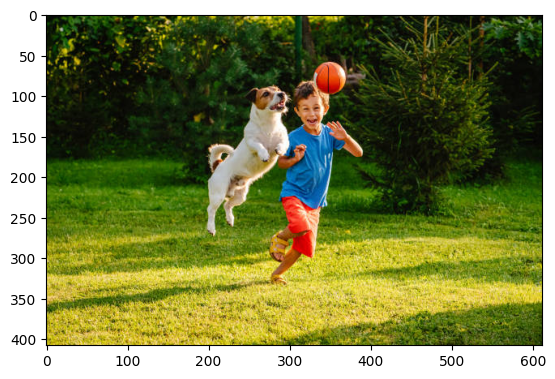

startseq dog is running through the grass endseq


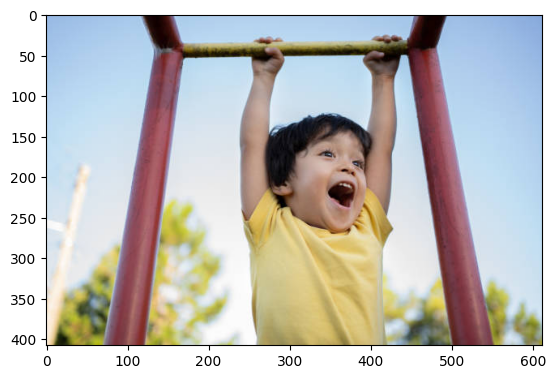

startseq little boy is playing with toy in the grass endseq


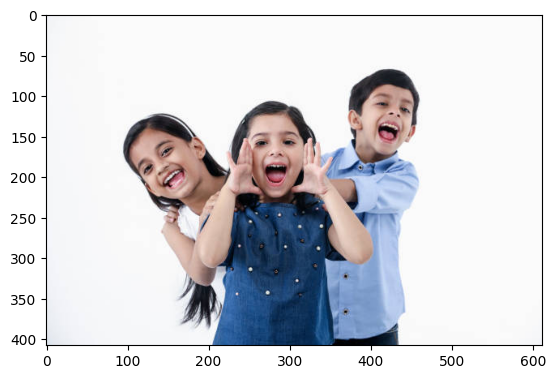

startseq two girls are playing on gaurd rails endseq


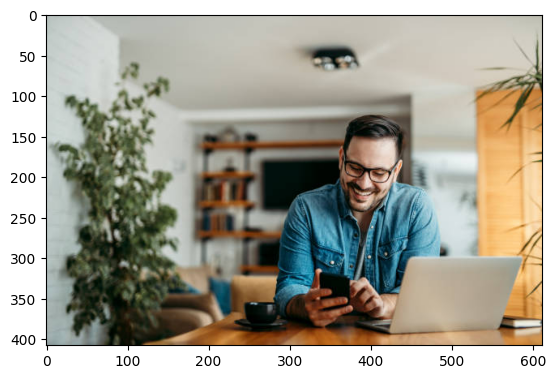

startseq two girls are playing on gaurd rails endseq


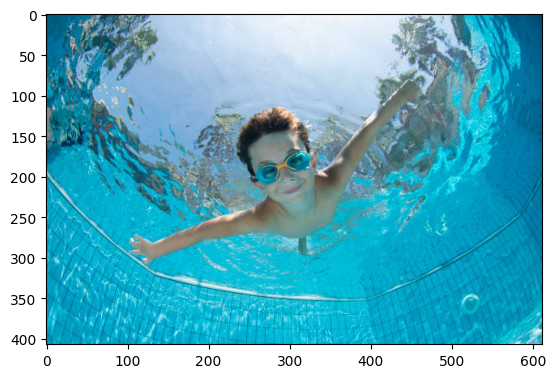

startseq boy in red shirt is jumping into pool endseq


In [ ]:
for key in photo:
    show_image(input_file+key+'.jpg')
    yhat = generate_desc(model, tokenizer, photo[key], max_length)
    print(yhat)

https://www.kaggle.com/code/khanrahim/flickr8k-inception/notebook